In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 4.9 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.3-cp310-cp310-linux_x86_64.whl size=293152 sha256=c5e6fa63ee35aa527db141306e2bf2594cb60817a5e8041040c447ee85ed9fcc
  Stored in directory: /root/.cache/pip/wheels/0d/32/b7/cad9f818b37cf97df4c87a8308da86a433af81651d98f8d8aa
Successfully built peewee


In [2]:
# Create a directory if it is not there, so we can save files and results in it
from pathlib import Path
Path('/kaggle/working/lstm3d').mkdir(parents=True,exist_ok=True)

In [3]:
import numpy as np
import pandas as pd
import math
import os
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import yfinance as yf
import tensorflow as tf

2024-04-20 16:25:45.337343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 16:25:45.337440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 16:25:45.433096: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def stock_predict_3D(stock_name,filename):
    stock_data = yf.download(stock_name, start='2020-01-01', end='2024-01-01')
    specific_df = pd.DataFrame(stock_data).reset_index()
    specific_df['Name'] = stock_name
    # print(specific_df.head())

    new_df = specific_df.reset_index()['Close']

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

    from sklearn.model_selection import train_test_split
    test_size = 0.2
    train_data, test_data = train_test_split(scaled_data, test_size=test_size, shuffle=False)

    def generate_sequences_and_labels(data, n_past):
        sequences = [data[i - n_past:i, 0] for i in range(n_past, len(data))]
        labels = [data[i, 0] for i in range(n_past, len(data))]
        return np.array(sequences), np.array(labels)

    n_past = 60
    x_train, y_train = generate_sequences_and_labels(train_data, n_past)
    x_test, y_test = generate_sequences_and_labels(test_data, n_past)

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

    ################################### START ##########################################

    def build_lstm_model(input_shape):
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=[x_train.shape[1], 1]))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        return model

    def compile_lstm_model(model):
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    def train_lstm_model(model, x_train, y_train, x_test, y_test):
        model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=250, batch_size=32, verbose=0)

    model = build_lstm_model(x_train.shape[1])
    compile_lstm_model(model)
    train_lstm_model(model, x_train, y_train, x_test, y_test)

    ######################################## END #######################################

    folder_path = "/kaggle/working/lstm3d/"  # Get the current script's directory
    filename_a = folder_path+filename+'_lstm3d.keras'
    model.save(filename_a)
    
    # folder_path = os.path.dirname(os.path.abspath(__file__))
#     filename_a = filename + "3D.keras"
    # model.save(filename_a)

#     model = tf.keras.models.load_model(filename_a)

    def make_predictions(model, x_train, x_test):
        train_predict = model.predict(x_train)
        test_predict = model.predict(x_test)
        return train_predict, test_predict

    train_predict, test_predict = make_predictions(model, x_train, x_test)

    def inverse_transform(scaler, y_train, train_predict, y_test, test_predict):
        y_test = y_test.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        y_test = scaler.inverse_transform(y_test)
        y_train = scaler.inverse_transform(y_train)
        train_predict = scaler.inverse_transform(train_predict)
        test_predict = scaler.inverse_transform(test_predict)
        return y_test, y_train, train_predict, test_predict

    y_test, y_train, train_predict, test_predict = inverse_transform(scaler, y_train, train_predict, y_test, test_predict)

    def evaluate_model(y_train, train_predict, y_test, test_predict):
        # train_mse = mean_squared_error(y_train, train_predict)
        test_mse = mean_squared_error(y_test, test_predict)
        test_mae = mean_absolute_error(y_test, test_predict)
        test_mape = mean_absolute_percentage_error(y_test, test_predict)
        test_rs = r2_score(y_test, test_predict)
        # print(f"Training MSE: {train_mse}")
        print(f"MSE of {stock_name}: {test_mse}")
        print(f"MAE of {stock_name}: {test_mae}")
        print(f"MAPE of {stock_name}: {test_mape}")
        print(f"R Squared of {stock_name}: {test_rs}")

    evaluate_model(y_train, train_predict, y_test, test_predict)

    predictions = model.predict(x_test)
    actual_values_inverse = y_test

    predicted_values_inverse = scaler.inverse_transform(predictions)

    plt.figure(figsize=(10, 5))
    plt.plot(actual_values_inverse.flatten(), label="Actual Close Prices")
    plt.plot(predicted_values_inverse.flatten(), 'r', label="Predicted Close Prices")
    plt.ylabel('Close Price')
    plt.xlabel('Time Step')
    plt.legend()
    plt.title(stock_name+'-LSTM 3D')
    plt_name = folder_path+filename+'_lstm3d.png'
    plt.savefig(plt_name)

In [5]:
stock_list = ["AAPL","AMGN","AXP","BA","CAT","CRM","CSCO","CVX","DIS","DOW","GS","HD","HON",
              "IBM","INTC","JNJ","JPM","KO","MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH",
              "V","VZ","WBA","WMT"]
print(len(stock_list))

30


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of AAPL: 6.199308179117224
MAE of AAPL: 1.9952238915671756
MAPE of AAPL: 0.010822984216539317
R Squared of AAPL: 0.9055506983344612
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of AMGN: 17.473239515111192
MAE of AMGN: 3.1555773238061176
MAPE of AMGN: 0.012119121655444685
R Squared of AMGN: 0.9556570724544032
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of AXP: 4.914927541821032
MAE of AXP: 1.6772584512200157
MAPE of AXP: 0.010332222416781663
R Squared of AXP: 0.9587845346031588
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of BA: 15.253665995802134
MAE of BA: 2.9109388539488887
MAPE of BA: 0.013579299835472574
R Squared of BA: 0.9674113312717948
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of CAT: 21.8616066013076
MAE of CAT: 3.416197440993619
MAPE of CAT: 0.012967917088531747
R Squared of CAT: 0.929608833794615
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of CRM: 13.7748426659587
MAE of CRM: 2.6945840540066586
MAPE of CRM: 0.012262634019512183
R Squared of CRM: 0.9579487884665506
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of CSCO: 0.4773716467068265
MAE of CSCO: 0.43935088036765513
MAPE of CSCO: 0.008479077359457115
R Squared of CSCO: 0.9216656701663271
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of CVX: 6.210414879296208
MAE of CVX: 1.80592432156415
MAPE of CVX: 0.011657743783336456
R Squared of CVX: 0.9080334941646044
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of DIS: 17.2277409323146
MAE of DIS: 3.947243972563408
MAPE of DIS: 0.04574018319664889
R Squared of DIS: 0.0940842025405656
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of DOW: 0.468224841664984
MAE of DOW: 0.5356097154214352
MAPE of DOW: 0.010213620618889037
R Squared of DOW: 0.8931669884437058
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of GS: 27.69246716215605
MAE of GS: 4.052651633679028
MAPE of GS: 0.012227800739821607
R Squared of GS: 0.9356077443657792
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of HD: 15.197089091126971
MAE of HD: 2.95185615647007
MAPE of HD: 0.009451682701355699
R Squared of HD: 0.9536760215709204
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of HON: 4.697142591744228
MAE of HON: 1.6800946517729423
MAPE of HON: 0.008708870596396369
R Squared of HON: 0.9412222864804133
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of IBM: 2.8485765439641804
MAE of IBM: 1.382623376980633
MAPE of IBM: 0.009451403571754984
R Squared of IBM: 0.9649669634263397
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of INTC: 1.2180550943017725
MAE of INTC: 0.8816723487746547
MAPE of INTC: 0.023806573990787634
R Squared of INTC: 0.9420296287873261
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of JNJ: 3.201334284893959
MAE of JNJ: 1.251980203977773
MAPE of JNJ: 0.0078011295451205585
R Squared of JNJ: 0.9374992206331957
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of JPM: 2.9473186356300802
MAE of JPM: 1.3459271713041923
MAPE of JPM: 0.00889990522265496
R Squared of JPM: 0.9498447669314208
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of KO: 0.3908307401331811
MAE of KO: 0.5077855284784886
MAPE of KO: 0.008665288922625641
R Squared of KO: 0.9349238631662652
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of MCD: 17.01950077984718
MAE of MCD: 3.6442699163732395
MAPE of MCD: 0.012957752029315567
R Squared of MCD: 0.9130148445412082
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of MMM: 3.988964396089473
MAE of MMM: 1.6573056503080985
MAPE of MMM: 0.020285059984610818
R Squared of MMM: 0.8644768836950767
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of MRK: 4.108401480329249
MAE of MRK: 1.7151616056200485
MAPE of MRK: 0.015954846117196834
R Squared of MRK: 0.6312280159162758
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/tmp/ipykernel_34/4195594282.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))
[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of MSFT: 46.47309449366884
MAE of MSFT: 5.7294541479836045
MAPE of MSFT: 0.01661749767661607
R Squared of MSFT: 0.8835770057393091
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of NKE: 4.849101344016495
MAE of NKE: 1.4868787846095126
MAPE of NKE: 0.014253529727764091
R Squared of NKE: 0.9054219713076909
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of PG: 1.9330208715769597
MAE of PG: 1.0856154535857727
MAPE of PG: 0.00722663253055803
R Squared of PG: 0.848559903163506
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of TRV: 3.7267373318711794
MAE of TRV: 1.5670638823173415
MAPE of TRV: 0.009210863112744888
R Squared of TRV: 0.9343957865384598
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of UNH: 49.83898887282207
MAE of UNH: 4.972297346088247
MAPE of UNH: 0.009980596633956224
R Squared of UNH: 0.9250471589367082
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of V: 4.505712517592923
MAE of V: 1.6820672263561833
MAPE of V: 0.007012274667468657
R Squared of V: 0.9503028254484919
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of VZ: 1.464408505788579
MAE of VZ: 1.0376666968976949
MAPE of VZ: 0.03076973172822518
R Squared of VZ: 0.6617388220340388
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of WBA: 2.0738007215854273
MAE of WBA: 1.286451299425582
MAPE of WBA: 0.05378948264842254
R Squared of WBA: 0.8676109582499337
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


[*********************100%%**********************]  1 of 1 completed
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MSE of WMT: 3.600550543471374
MAE of WMT: 1.7501197600028886
MAPE of WMT: 0.03293796285755565
R Squared of WMT: -1.1267238769423096
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


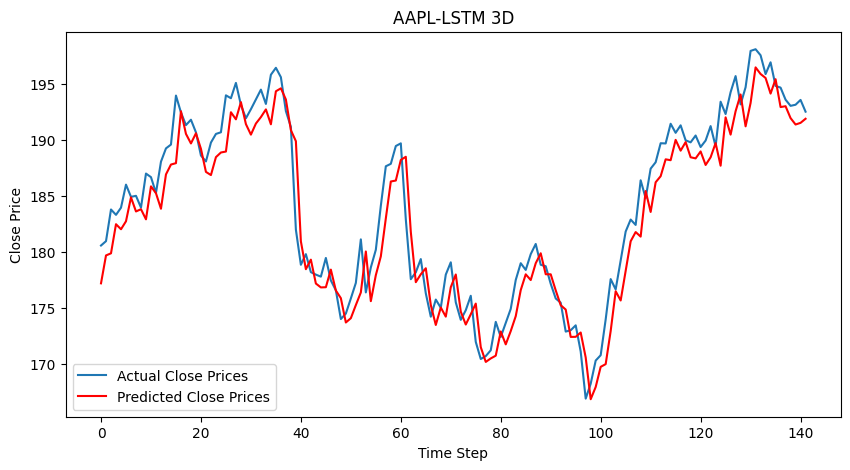

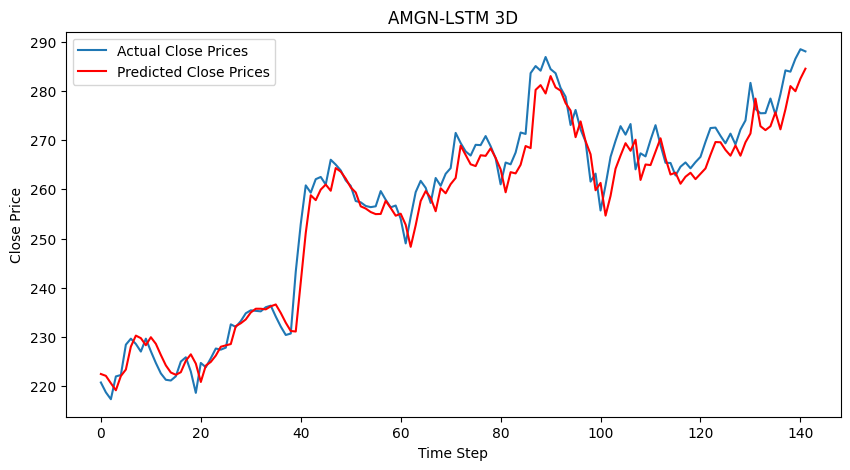

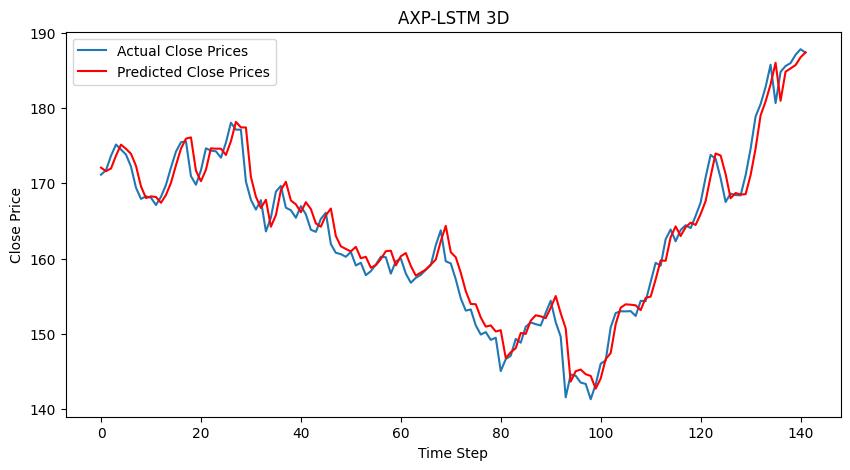

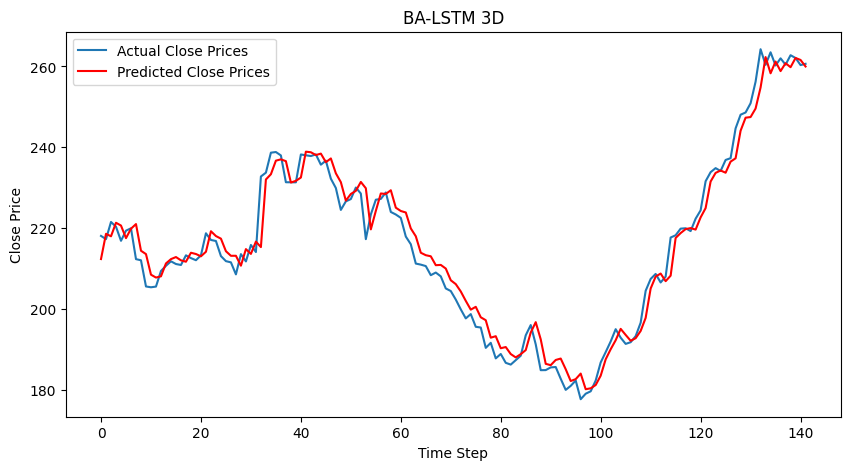

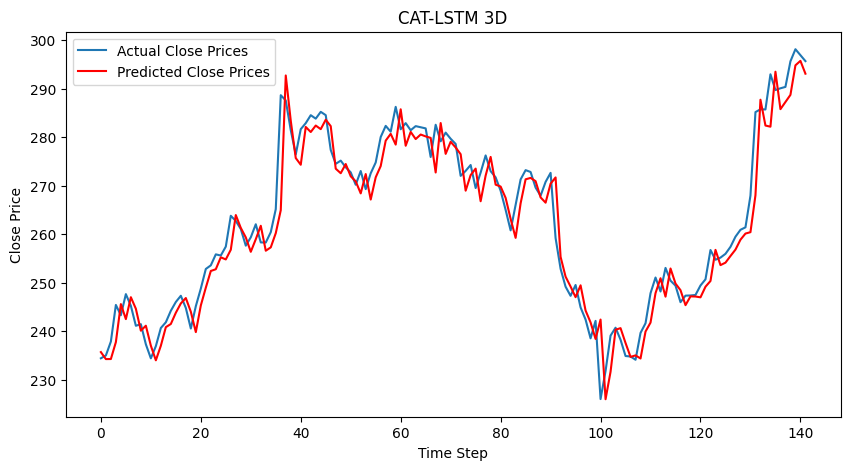

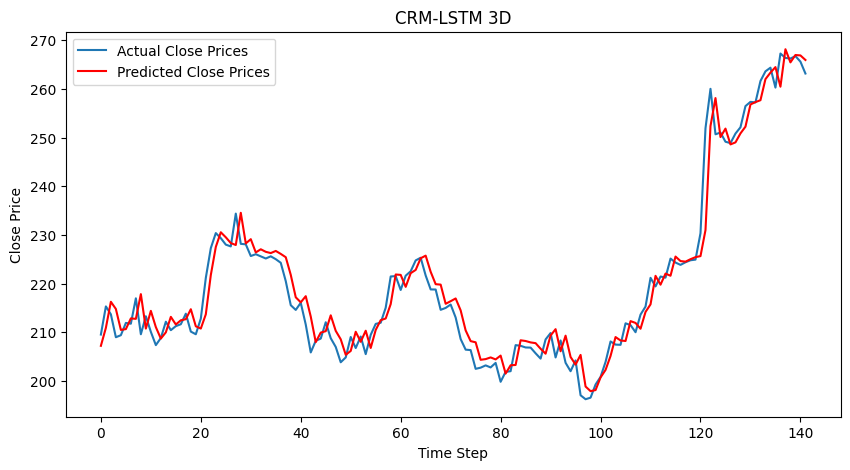

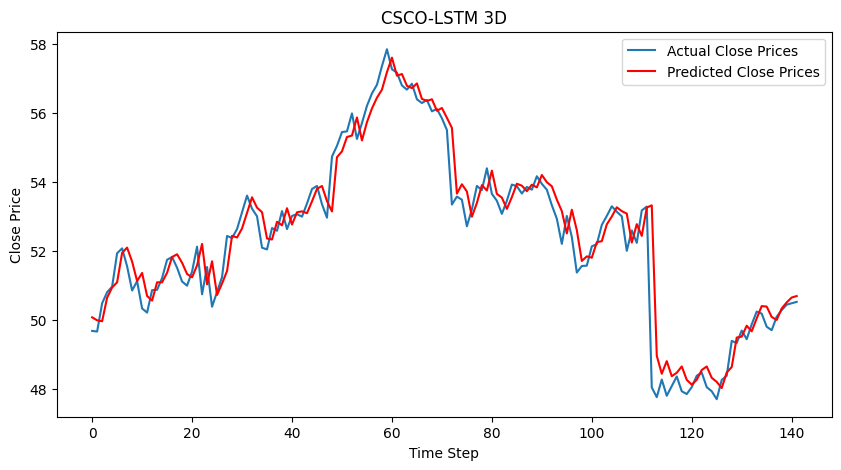

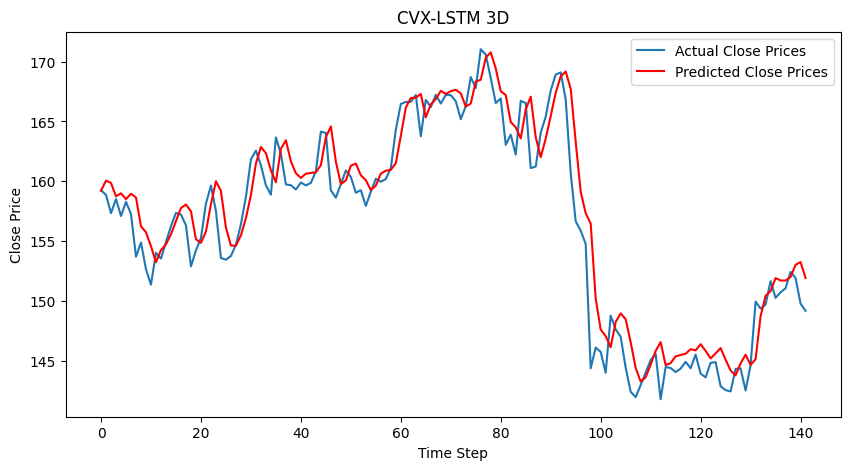

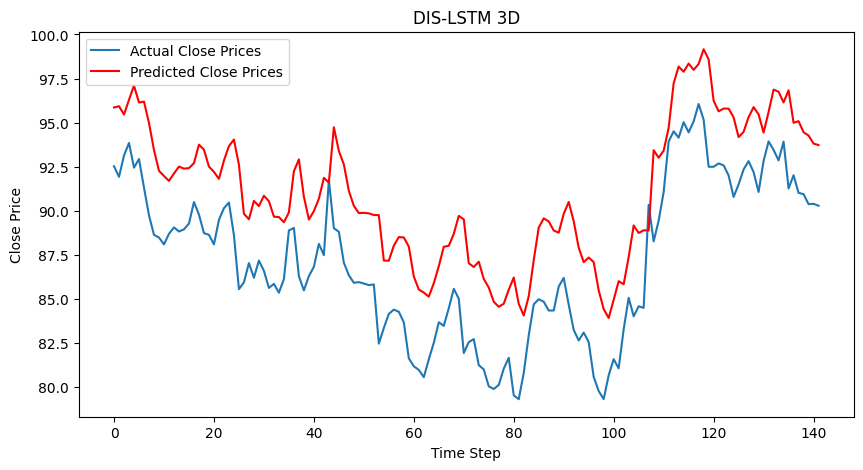

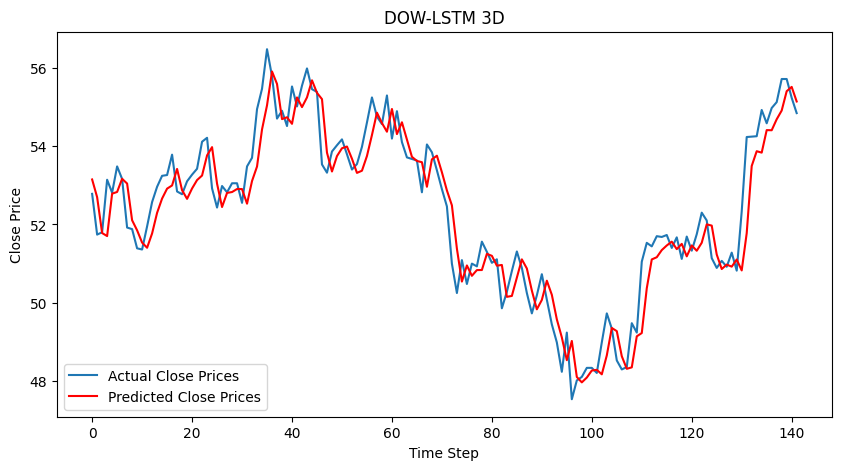

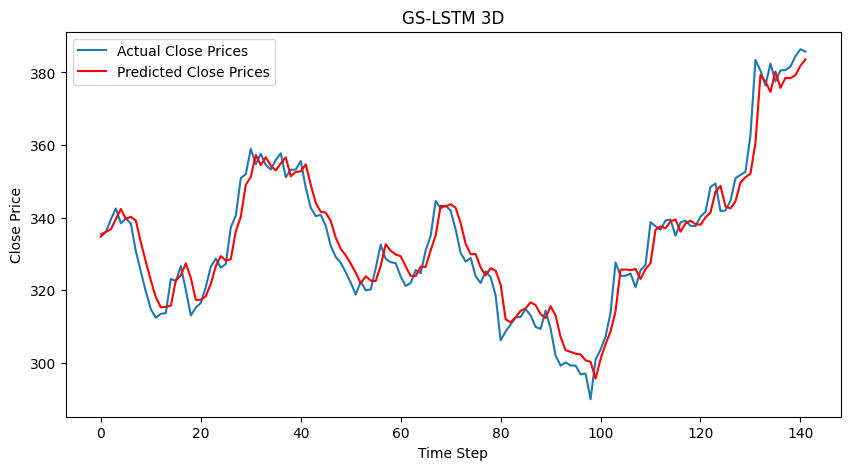

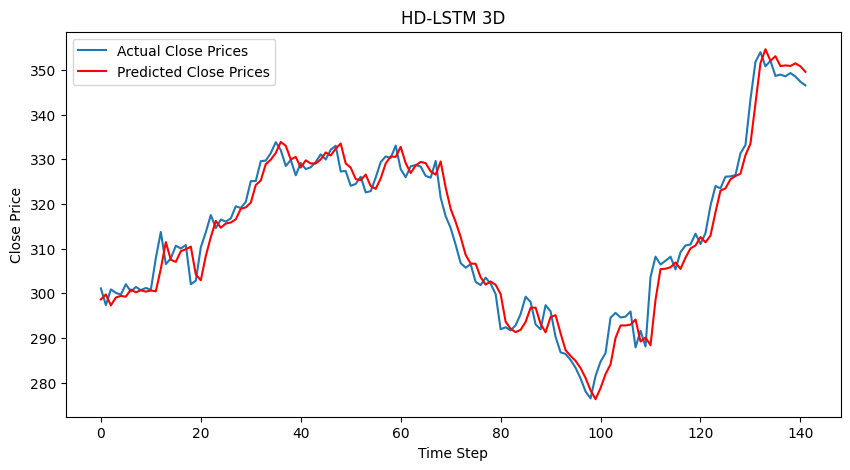

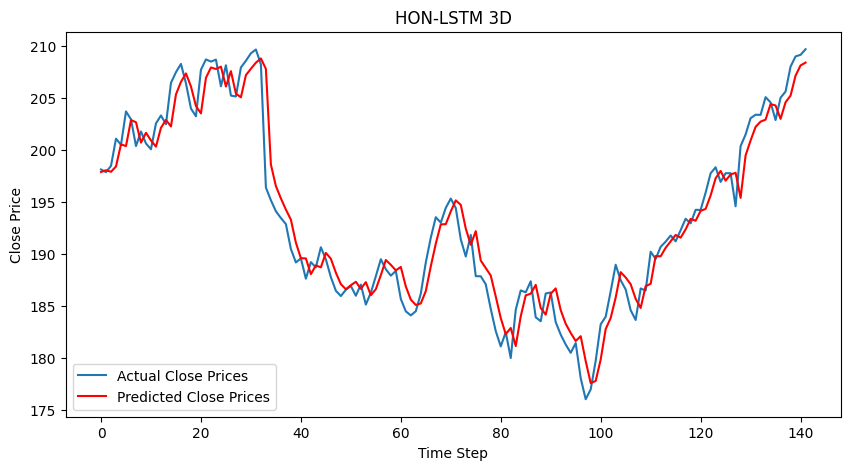

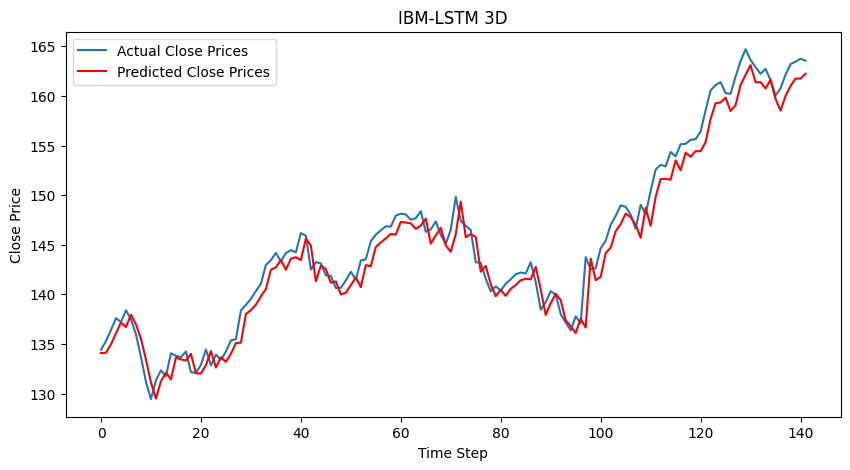

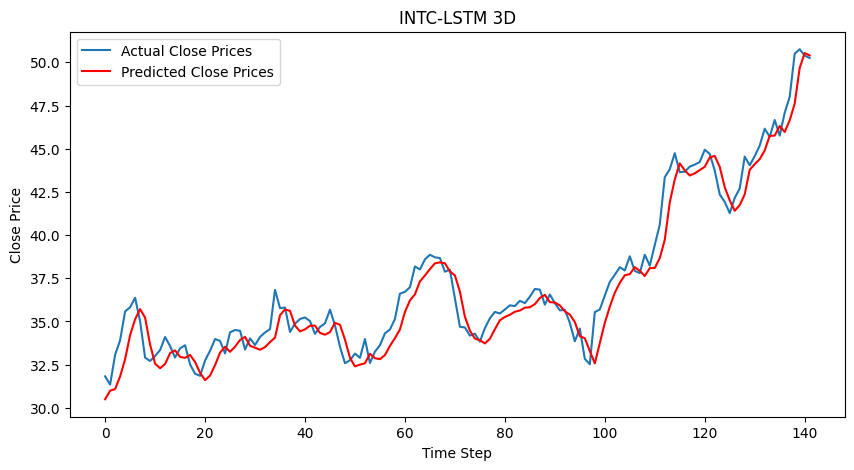

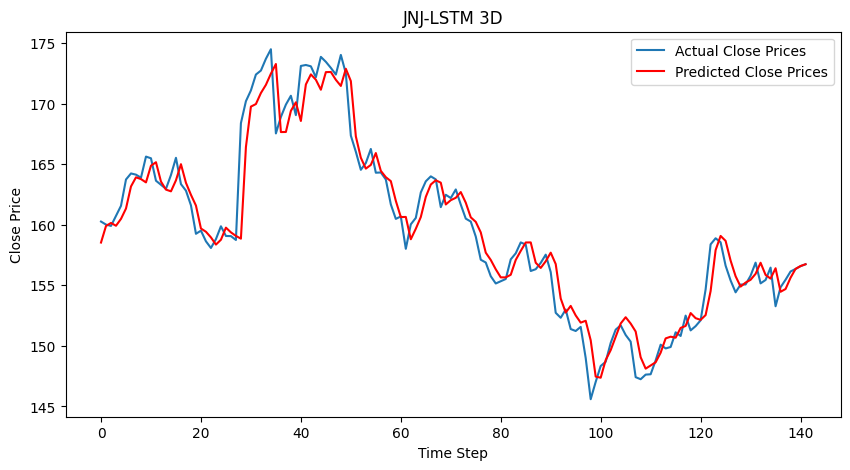

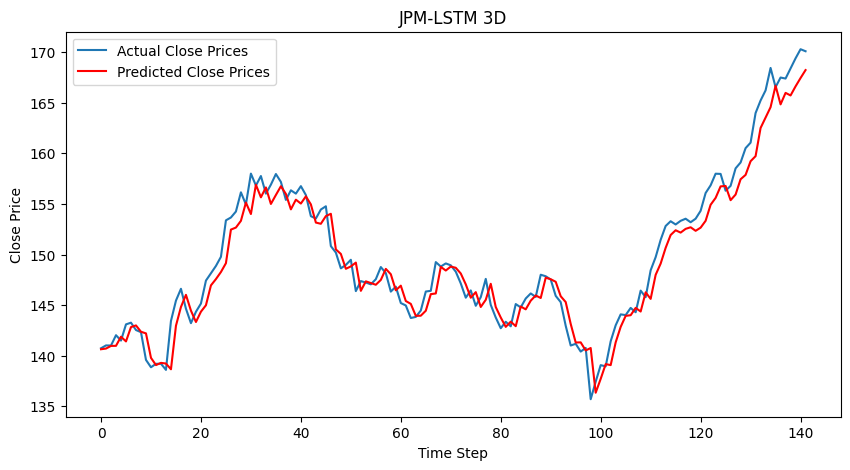

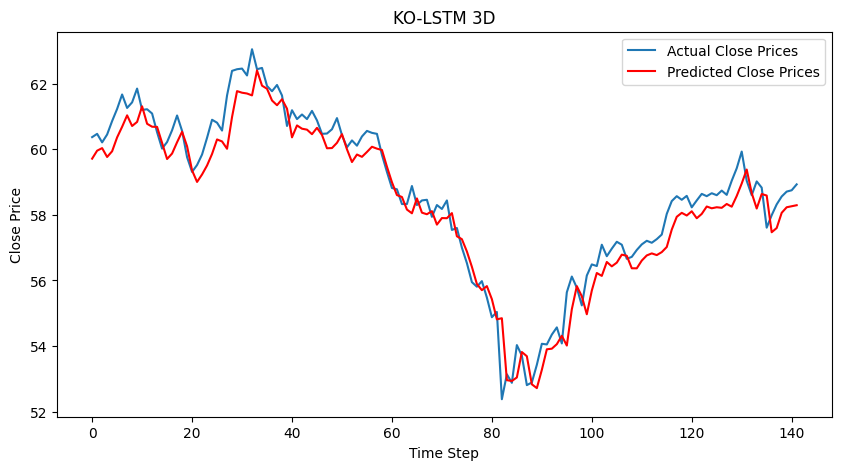

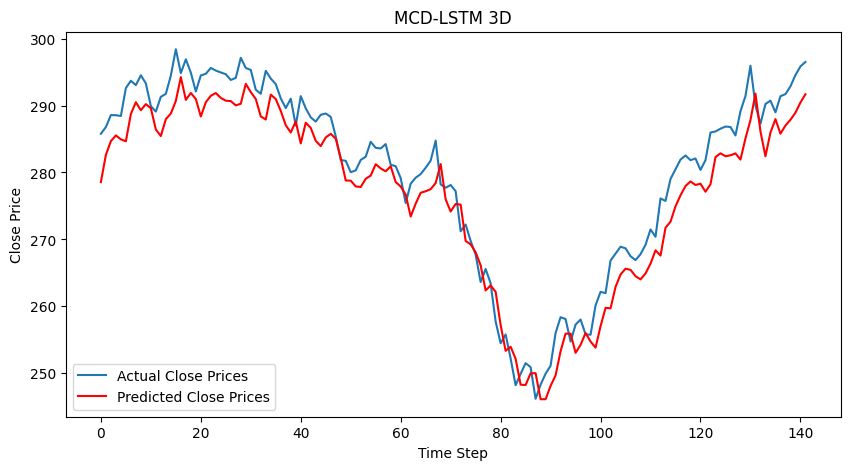

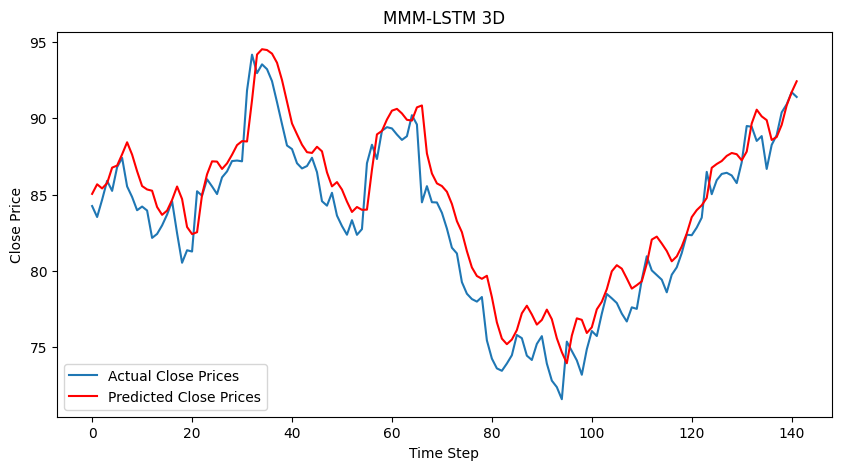

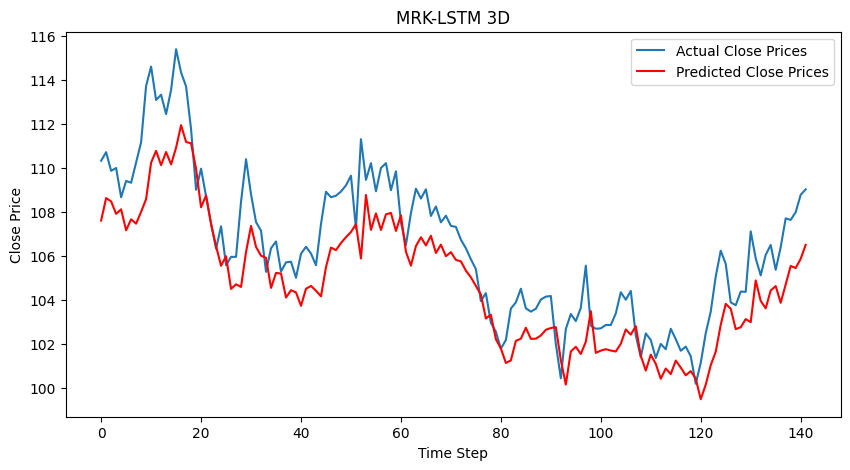

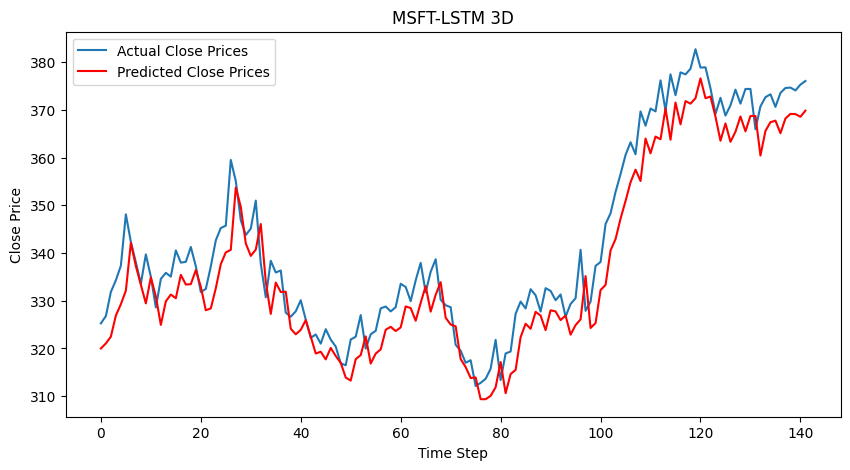

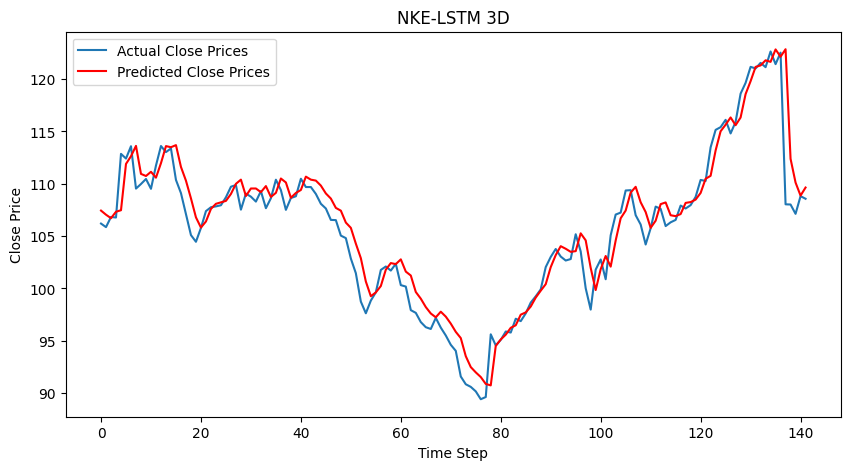

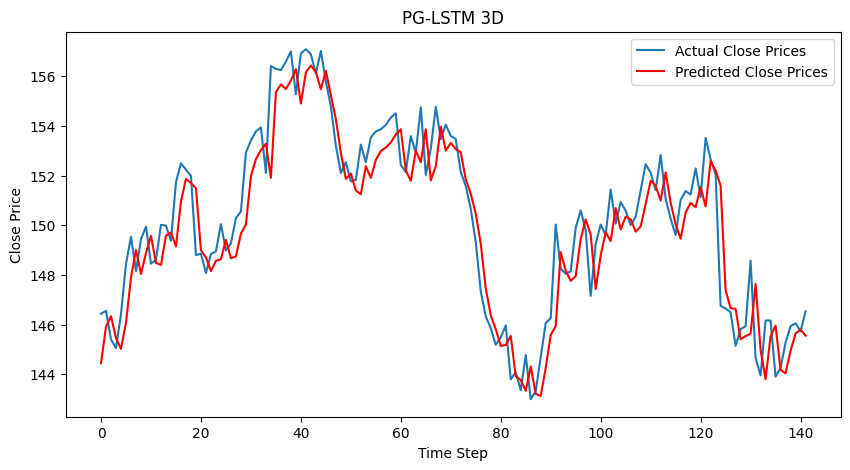

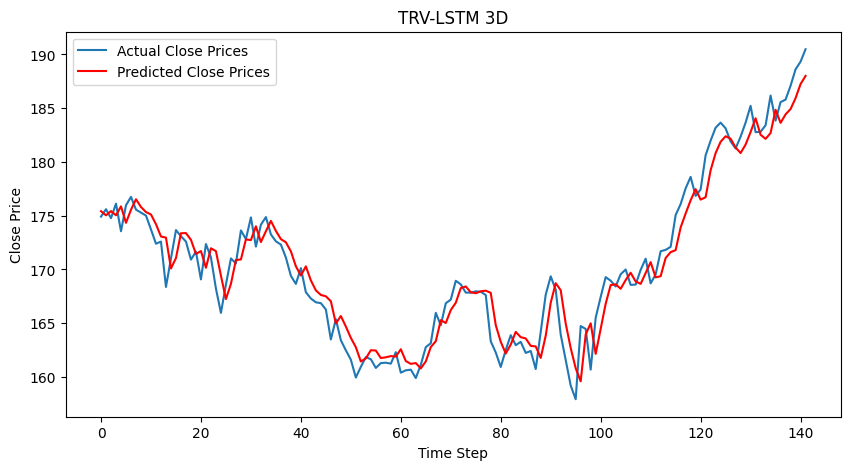

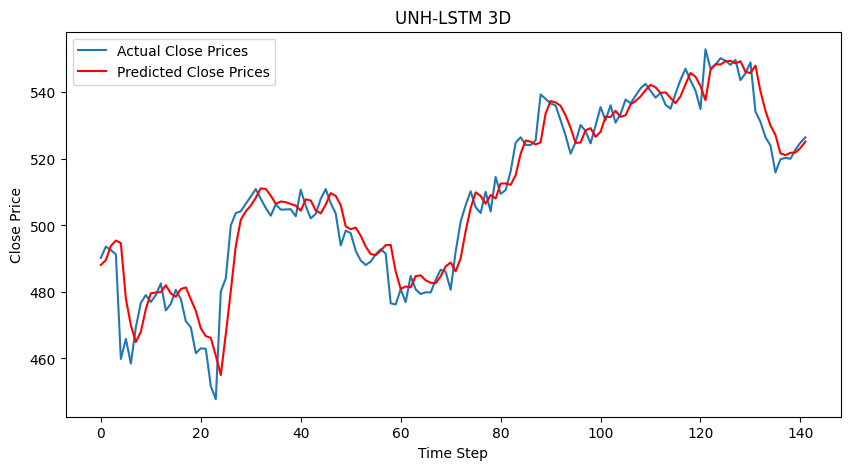

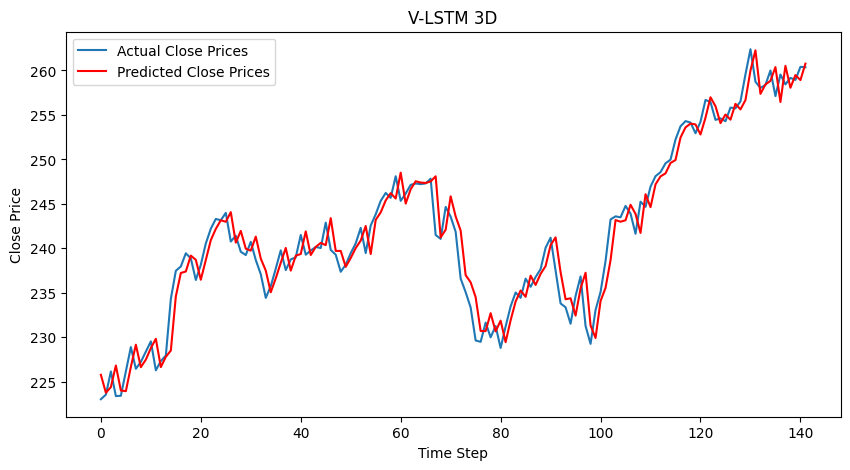

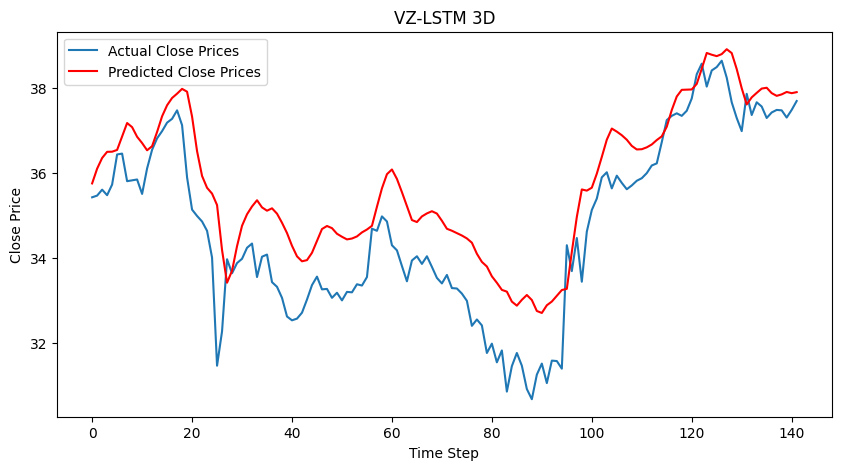

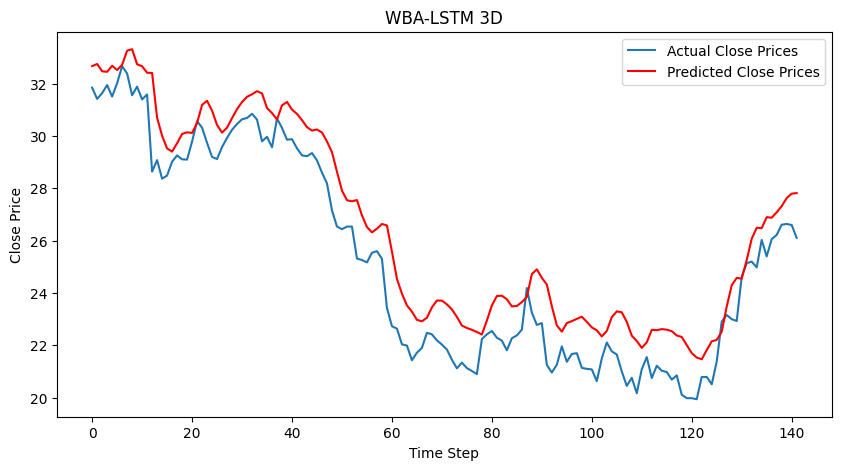

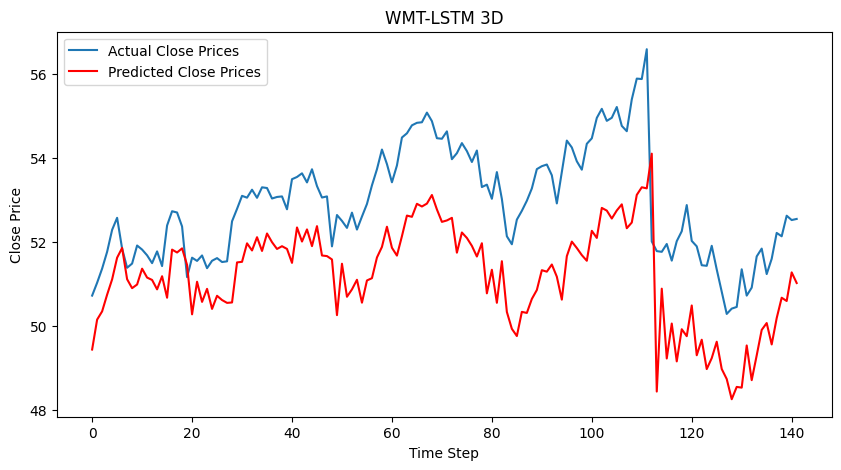

In [6]:
for stock in stock_list:
    stock_predict_3D(stock,stock)

In [7]:
!cd /kaggle/working
!zip -r lstm3d.zip /kaggle/working/lstm3d

  adding: kaggle/working/lstm3d/ (stored 0%)
  adding: kaggle/working/lstm3d/INTC_lstm2d.png (deflated 6%)
  adding: kaggle/working/lstm3d/MCD_lstm3d.keras (deflated 11%)
  adding: kaggle/working/lstm3d/DOW_lstm2d.png (deflated 4%)
  adding: kaggle/working/lstm3d/V_lstm3d.keras (deflated 11%)
  adding: kaggle/working/lstm3d/JNJ_lstm3d.keras (deflated 11%)
  adding: kaggle/working/lstm3d/GS_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm3d/GS_lstm3d.keras (deflated 11%)
  adding: kaggle/working/lstm3d/CRM_lstm2d.png (deflated 6%)
  adding: kaggle/working/lstm3d/BA_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm3d/DIS_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm3d/DOW_lstm3d.keras (deflated 11%)
  adding: kaggle/working/lstm3d/IBM_lstm3d.keras (deflated 11%)
  adding: kaggle/working/lstm3d/NKE_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm3d/WBA_lstm2d.png (deflated 5%)
  adding: kaggle/working/lstm3d/KO_lstm3d.keras (deflated 11%)
  adding: kaggle/working